        Date  Maize_Production_MT  Rainfall_mm  Drought_Index     Price_KES  \
0 2013-01-31          1099.342831    87.319856       0.045603   2713.484463   
1 2013-02-28          2071.689970    22.402169       0.247210   4876.091836   
2 2013-03-31          3201.227678    76.346842       0.028779   6915.857585   
3 2013-04-30          4505.833649   191.862522       0.274764   9799.160631   
4 2013-05-31          5459.002974    20.611857       0.220765  12398.854835   

   Year  Month  
0  2013      1  
1  2013      2  
2  2013      3  
3  2013      4  
4  2013      5  
Epoch 1/100


/tmp/ipython-input-9-2040722366.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2013-01-01', periods=years*12, freq='M')
/tmp/ipython-input-9-2040722366.py:38: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.1669 - mae: 0.3651 - val_loss: 0.4444 - val_mae: 0.6657
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1317 - mae: 0.3213 - val_loss: 0.3268 - val_mae: 0.5707
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0837 - mae: 0.2461 - val_loss: 0.2206 - val_mae: 0.4685
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0465 - mae: 0.1767 - val_loss: 0.1235 - val_mae: 0.3501
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0349 - mae: 0.1520 - val_loss: 0.0437 - val_mae: 0.2073
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0143 - mae: 0.0956 - val_loss: 0.0030 - val_mae: 0.0491
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0119 - mae: 0.0873 - val_loss: 0.0061 - val_mae: 0.0749
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0207 - mae: 0.1293 - val_loss: 0.0052 - val_mae: 0.0687
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0153 - mae: 0.1042 - va

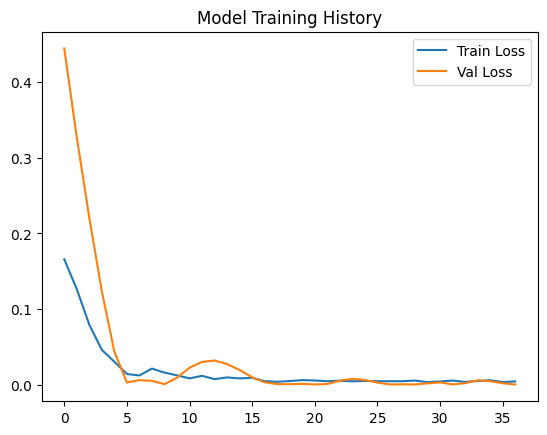


Drift detected: False
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

No shortage predicted


In [9]:
# ======================
# 1. Imports & Setup
# ======================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================
# 2. Synthetic Data Generation
# ======================
def generate_synthetic_data(years=10):
    np.random.seed(42)
    dates = pd.date_range(start='2013-01-01', periods=years*12, freq='M')
    data = {
        'Date': dates,
        'Maize_Production_MT': np.random.normal(1000, 200, len(dates)).cumsum(),
        'Rainfall_mm': np.random.gamma(shape=2, scale=30, size=len(dates)),
        'Drought_Index': np.random.uniform(0, 0.5, len(dates)),
        'Price_KES': np.random.normal(2500, 300, len(dates)).cumsum()
    }
    df = pd.DataFrame(data)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    return df

df = generate_synthetic_data()
print(df.head())

# ======================
# 3. Data Preprocessing
# ======================
# Handle missing values
df.fillna(method='ffill', inplace=True)

# Normalization
scaler = MinMaxScaler()
features = ['Maize_Production_MT', 'Rainfall_mm', 'Drought_Index', 'Price_KES']
df[features] = scaler.fit_transform(df[features])

# Time-series formatting
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps, 0])  # Predicting production
    return np.array(X), np.array(y)

n_steps = 12  # 1-year lookback
X, y = create_sequences(df[features].values, n_steps)

# Train/Val/Test Split (temporal)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

# ======================
# 4. Model Development
# ======================
model = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, len(features))),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# Training
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

# ======================
# 5. Evaluation
# ======================
def evaluate_model(model, X, y):
    loss, mae = model.evaluate(X, y, verbose=0)
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {np.sqrt(loss):.4f}")

print("\nTest Set Evaluation:")
evaluate_model(model, X_test, y_test)

# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Training History')
plt.show()

# ======================
# 6. Concept Drift Monitoring
# ======================
class ConceptDriftDetector:
    def __init__(self, window_size=6, threshold=0.15):
        self.window_size = window_size
        self.threshold = threshold
        self.baseline_rmse = None

    def update_baseline(self, model, X_val, y_val):
        loss = model.evaluate(X_val, y_val, verbose=0)[0]
        self.baseline_rmse = np.sqrt(loss)

    def check_drift(self, model, X_new, y_new):
        current_loss = model.evaluate(X_new, y_new, verbose=0)[0]
        current_rmse = np.sqrt(current_loss)
        drift = (current_rmse - self.baseline_rmse) / self.baseline_rmse
        return drift > self.threshold

# Initialize detector
drift_detector = ConceptDriftDetector()
drift_detector.update_baseline(model, X_val, y_val)

# Simulate drift detection
print(f"\nDrift detected: {drift_detector.check_drift(model, X_test, y_test)}")

# ======================
# 7. Deployment Simulation
# ======================
def predict_shortage(model, latest_data, shortage_threshold=0.3):
    """Predict if shortage will occur next month"""
    prediction = model.predict(latest_data.reshape(1, n_steps, len(features)))
    return prediction[0][0] < shortage_threshold

# Example usage
latest_sequence = X_test[-1]  # Most recent data
if predict_shortage(model, latest_sequence):
    print("\nALERT: Potential grain shortage predicted next month!")
else:
    print("\nNo shortage predicted")

In [7]:
# Ensure your notebook is saved with the correct name
from google.colab import drive
drive.mount('/content/drive')  # Only if using Google Drive

# Save a copy (replace with your actual notebook name)
!cp "/content/drive/MyDrive/Colab Notebooks/Grain Demand Supply Prediction.ipynb" "/content/Grain Demand Supply Prediction.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!jupyter nbconvert --to python "/content/Grain Demand/Supply Prediction.ipynb"

[NbConvertApp] WARNING | pattern '/content/Grain Demand/Supply Prediction.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.an